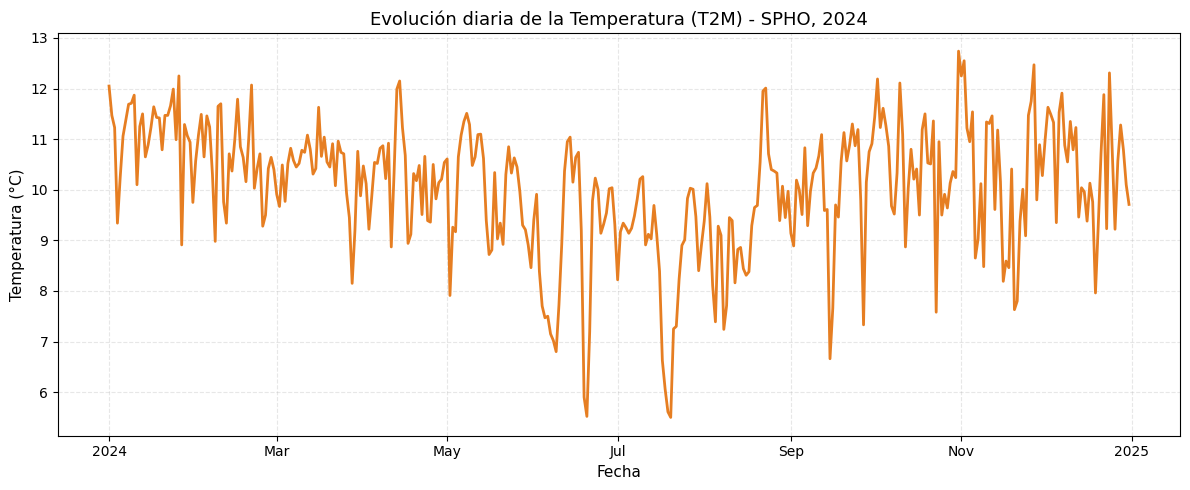

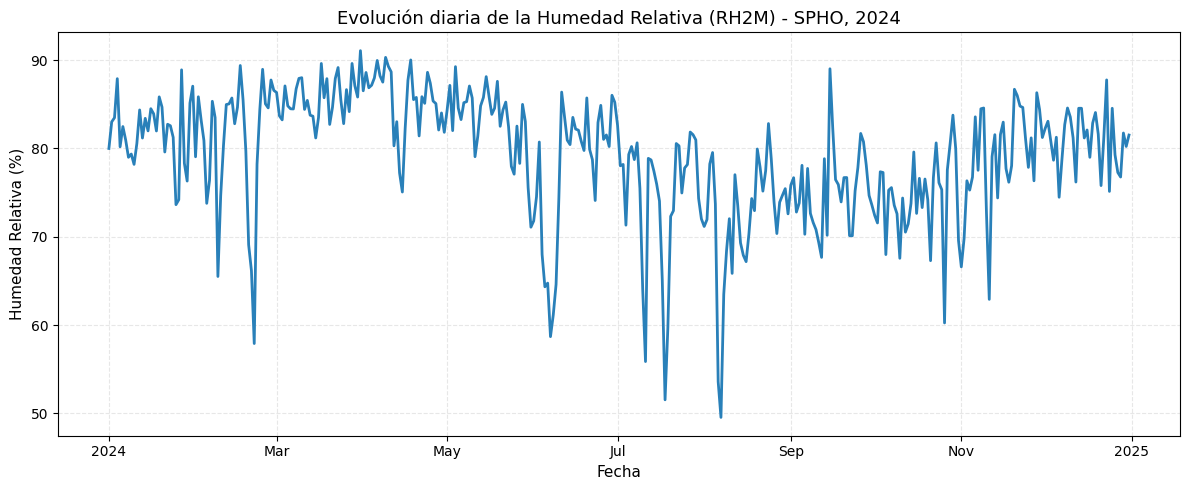

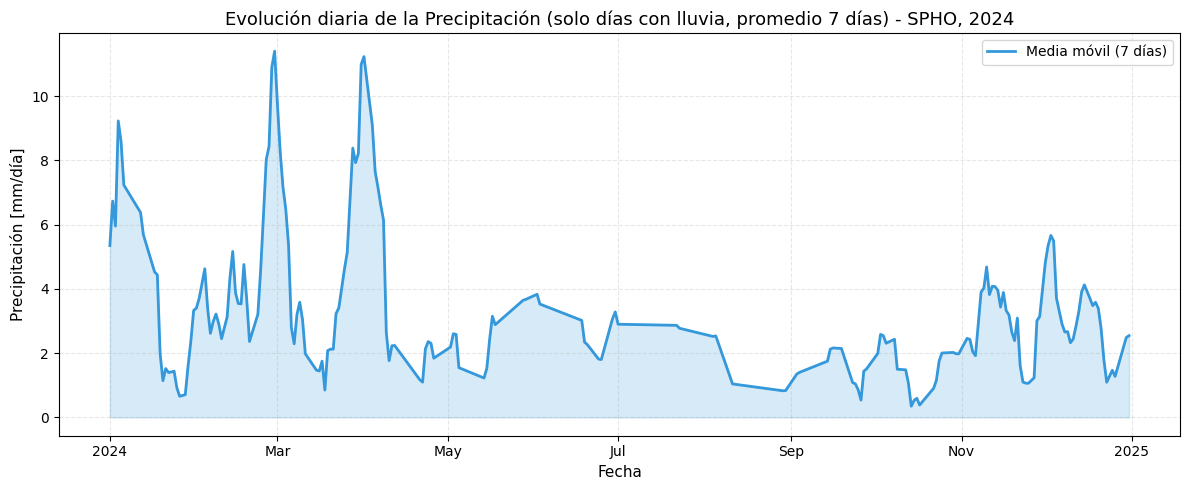

In [ ]:
# -*- coding: utf-8 -*-
# Graficador NASA POWER (Daily) — T2M y RH2M (versión con gráficos de líneas mejorados)

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter

# --- Si el archivo está en Google Drive, descomenta estas 3 líneas ---
# from google.colab import drive
# drive.mount('/content/drive')
# CSV_PATH = Path("/content/drive/MyDrive/BPA/nasa/Daily_20240101_20241231_013d14S_074d19W_LST_DAILY.csv")

# Si lo subes a la sesión (Colab > subir archivo), usa:
# CSV_PATH = Path("/content/Daily_20240101_20241231_013d14S_074d19W_LST_DAILY.csv")

# ====== RUTA DEL CSV ======
CSV_PATH = Path("/content/drive/MyDrive/BPA/nasa/Daily_20240101_20241231_013d14S_074d19W_LST_DAILY.csv")

# --------- Utilidades ---------
def detect_header_row(csv_path: Path) -> int:
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            tokens = [t.strip().upper() for t in line.split(",")]
            if ("T2M" in tokens or any("T2M" in t for t in tokens)) and (
                {"YEAR","MO","DY"}.issubset(set(tokens))
                or "DATE" in tokens
                or "YYYYMMDD" in tokens
            ):
                return i
            keys = {"YEAR","MO","DY","DATE","DOY","YYYYMMDD","T2M","RH2M"}
            if sum(1 for t in tokens if t in keys) >= 3:
                return i
    return 0

hdr = detect_header_row(CSV_PATH)
df = pd.read_csv(CSV_PATH, skiprows=hdr)
df.columns = [c.strip().upper() for c in df.columns]

# Construcción de la fecha
if {"YEAR","MO","DY"}.issubset(df.columns):
    fecha = pd.to_datetime(dict(year=df["YEAR"], month=df["MO"], day=df["DY"]), errors="coerce")
elif "DATE" in df.columns:
    fecha = pd.to_datetime(df["DATE"].astype(str), errors="coerce", format="%Y%m%d")
    if fecha.isna().all():
        fecha = pd.to_datetime(df["DATE"], errors="coerce")
elif "YYYYMMDD" in df.columns:
    fecha = pd.to_datetime(df["YYYYMMDD"].astype(str), format="%Y%m%d", errors="coerce")
elif {"YEAR","DOY"}.issubset(df.columns):
    fecha = pd.to_datetime(df["YEAR"].astype(int).astype(str), format="%Y") + pd.to_timedelta(df["DOY"]-1, unit="D")
else:
    raise ValueError("No se pudo construir la columna de fecha con las columnas disponibles.")

df["FECHA"] = fecha
df = df.dropna(subset=["FECHA"]).sort_values("FECHA")

# Limpieza de datos
for col in ["T2M", "RH2M"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df.loc[df[col] < -900, col] = np.nan

# Carpeta de salida
OUTPUT_DIR = CSV_PATH.parent / "GRAFICOS_LINEAS"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --------- GRAFICO DE LINEAS: TEMPERATURA ---------
if "T2M" in df.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(df["FECHA"], df["T2M"], color="#e67e22", linewidth=2, linestyle='-')
    plt.title("Evolución diaria de la Temperatura (T2M) - SPHO, 2024", fontsize=13)
    plt.xlabel("Fecha", fontsize=11)
    plt.ylabel("Temperatura (°C)", fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.gca().xaxis.set_major_locator(AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(ConciseDateFormatter(plt.gca().xaxis.get_major_locator()))
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "01_T2M_LINEA_SPHO_2024.png", dpi=150)
    plt.show()
else:
    print("Columna T2M no encontrada en el CSV.")

# --------- GRAFICO DE LINEAS: HUMEDAD ---------
if "RH2M" in df.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(df["FECHA"], df["RH2M"], color="#2980b9", linewidth=2, linestyle='-')
    plt.title("Evolución diaria de la Humedad Relativa (RH2M) - SPHO, 2024", fontsize=13)
    plt.xlabel("Fecha", fontsize=11)
    plt.ylabel("Humedad Relativa (%)", fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.gca().xaxis.set_major_locator(AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(ConciseDateFormatter(plt.gca().xaxis.get_major_locator()))
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "02_RH2M_LINEA_SPHO_2024.png", dpi=150)
    plt.show()
else:
    print("Columna RH2M no encontrada en el CSV.")

    # --------- GRAFICO DE LÍNEAS SUAVIZADO: PRECIPITACIÓN ---------
# --------- GRAFICO DE LÍNEAS SUAVIZADO (sin ceros): PRECIPITACIÓN ---------
prec_cols = [c for c in ["PRECTOTCORR", "PRECTOT"] if c in df.columns]

if prec_cols:
    prec_col = prec_cols[0]

    # ---- Limpieza de datos ----
    df[prec_col] = pd.to_numeric(df[prec_col], errors="coerce")
    df.loc[df[prec_col] < 0, prec_col] = np.nan  # elimina negativos

    # ---- Filtro: eliminar los días sin lluvia (0 mm/día) ----
    df_filtrado = df[df[prec_col] > 0].copy()

    # ---- Suavizado (media móvil de 7 días) ----
    df_filtrado["PRECIP_SUAV"] = df_filtrado[prec_col].rolling(window=7, min_periods=1).mean()

    # ---- Gráfico ----
    plt.figure(figsize=(12, 5))
    plt.plot(df_filtrado["FECHA"], df_filtrado["PRECIP_SUAV"],
             color="#3498db", linewidth=2, label="Media móvil (7 días)")
    plt.fill_between(df_filtrado["FECHA"], 0, df_filtrado["PRECIP_SUAV"],
                     color="#3498db", alpha=0.2)
    plt.title("Evolución diaria de la Precipitación (solo días con lluvia, promedio 7 días) - SPHO, 2024", fontsize=13)
    plt.xlabel("Fecha", fontsize=11)
    plt.ylabel("Precipitación [mm/día]", fontsize=11)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.gca().xaxis.set_major_locator(AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(ConciseDateFormatter(plt.gca().xaxis.get_major_locator()))
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / "03_PRECIP_LINEA_SUAV_FILTRADA_SPHO_2024.png", dpi=150)
    plt.show()

else:
    print("No se encontró la columna PRECTOTCORR o PRECTOT en el CSV.")


